## ML-uppgift

### Vi börjar med att importera bibliotek och läsa in filen. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.model_selection import KFold


In [3]:

df = pd.read_csv('car_price_dataset.csv', sep=";")  


I mitt experimenterande visade det sig att separatorn i CSV-filen är ; och inte , - fixade det ovan.

Hur ser dataunderlaget ut?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [5]:
print(df.isnull().sum())

Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64


Inga null-värden

In [6]:
print(df.describe())
print(df.select_dtypes(include='object').nunique())


               Year   Engine_Size        Mileage         Doors   Owner_Count  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean    2011.543700      3.000560  149239.111800      3.497100      2.991100   
std        6.897699      1.149324   86322.348957      1.110097      1.422682   
min     2000.000000      1.000000      25.000000      2.000000      1.000000   
25%     2006.000000      2.000000   74649.250000      3.000000      2.000000   
50%     2012.000000      3.000000  149587.000000      3.000000      3.000000   
75%     2017.000000      4.000000  223577.500000      4.000000      4.000000   
max     2023.000000      5.000000  299947.000000      5.000000      5.000000   

             Price  
count  10000.00000  
mean    8852.96440  
std     3112.59681  
min     2000.00000  
25%     6646.00000  
50%     8858.50000  
75%    11086.50000  
max    18301.00000  
Brand           10
Model           30
Fuel_Type        4
Transmission     3
dtype: int64


Alla rader är unika, inga dubletter och inga värden saknas. Det finns tio bilmärken, 30 olika modeller, fyra bränsletyper och tre växellådor. Hur kan det finnas tre olika växellådor frågar sig vän av ordning? Vilka är det? Vi kollar.

In [7]:
print(df.Transmission.unique())

['Manual' 'Automatic' 'Semi-Automatic']


Frågan är hur semi-automatic och automatic skiljer sig? Kanske ska man slå ihop dessa till en så man får manuell eller automatisk växellåda? Vi kollar om det där semi-automatic kanske bara är brus som förvirrar modellen?


In [8]:
trans_pct = df["Transmission"].value_counts(normalize=True) * 100
print(trans_pct.round(1))


Transmission
Manual            33.7
Automatic         33.2
Semi-Automatic    33.1
Name: proportion, dtype: float64


Nej, det är en tredjedel av varje. Märkligt, men jag lämnar detta beslut tills jag ser hur priset korrelerar med de olika alternativen.

Först gör vi dock en enkel koll på de numeriska kolumnerna och hur de korrelererar med priset. 

In [9]:
numeric_cols = ["Year", "Engine_Size", "Mileage", "Doors", "Owner_Count", "Price"]
print(df[numeric_cols].corr()["Price"].sort_values(ascending=False))


Price          1.000000
Year           0.663036
Engine_Size    0.357403
Owner_Count    0.002656
Doors          0.000511
Mileage       -0.551227
Name: Price, dtype: float64


Och så de textbaserade kolumnerna. Vi stryker Brand ur hanteringen eftersom det ju implicit bestäms av Model

In [10]:
cats = ["Model", "Fuel_Type", "Transmission"]

# 1. Dummies
X_cat = pd.get_dummies(df[cats], drop_first=True)

# 2. Korrelationer för alla dummies mot Price
corrs = X_cat.join(df["Price"]).corr()["Price"]

# 3. Summera absoluta korrelationer per variabel
model_corr        = corrs[corrs.index.str.startswith("Model_")].abs().sum()
fuel_type_corr    = corrs[corrs.index.str.startswith("Fuel_Type_")].abs().sum()
transmission_corr = corrs[corrs.index.str.startswith("Transmission_")].abs().sum()

summary = pd.Series(
    {
        "Model": model_corr,
        "Fuel_Type": fuel_type_corr,
        "Transmission": transmission_corr,
    },
    name="Total_abs_corr_with_Price"
)

print(summary)


Model           0.219170
Fuel_Type       0.415330
Transmission    0.245259
Name: Total_abs_corr_with_Price, dtype: float64


Nu blir jag ändå lite misstänksam mot växellådorna där. Jag får kolla lite mer noga. 

In [11]:
print(df.groupby("Transmission")["Price"].describe())

med_iqr = df.groupby("Transmission")["Price"].agg(
    median="median",
    q1=lambda s: s.quantile(0.25),
    q3=lambda s: s.quantile(0.75)
)
print(med_iqr)


                 count         mean          std     min     25%      50%  \
Transmission                                                                
Automatic       3317.0  9938.252939  3025.692193  2000.0  7784.0  10034.0   
Manual          3372.0  8363.426157  3019.758983  2000.0  6159.5   8341.5   
Semi-Automatic  3311.0  8264.266385  3006.190812  2000.0  6069.0   8263.0   

                    75%      max  
Transmission                      
Automatic       12070.0  18301.0  
Manual          10514.5  16844.0  
Semi-Automatic  10364.5  17078.0  
                 median      q1       q3
Transmission                            
Automatic       10034.0  7784.0  12070.0
Manual           8341.5  6159.5  10514.5
Semi-Automatic   8263.0  6069.0  10364.5


Ajdå - semi-automatic är alltså en informativ feature ändå. Ja, ja - då får den vara kvar. 

# Plots för visualisering av data

För att tydliggöra hur data ser ut i underlaget kommer här ett gäng diagram. 

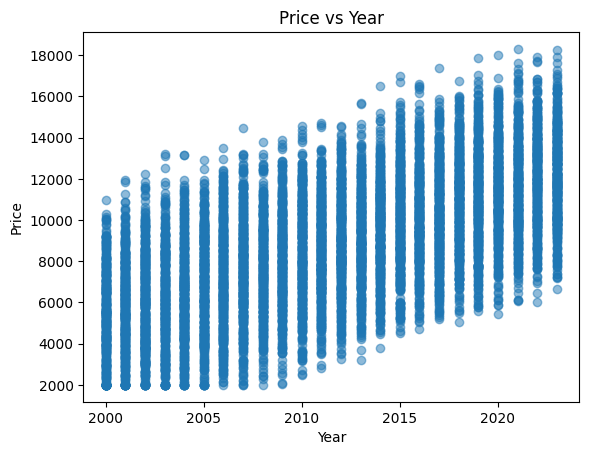

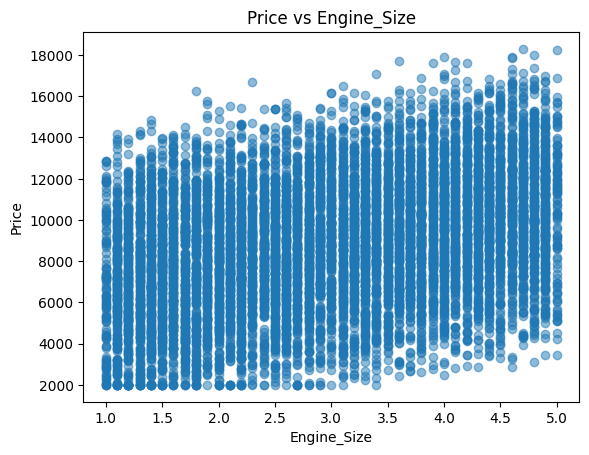

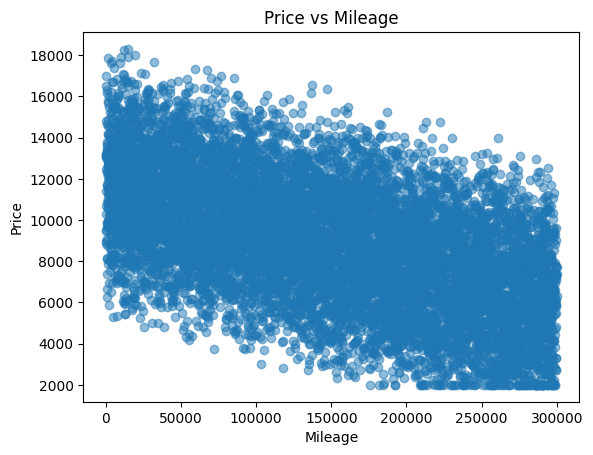

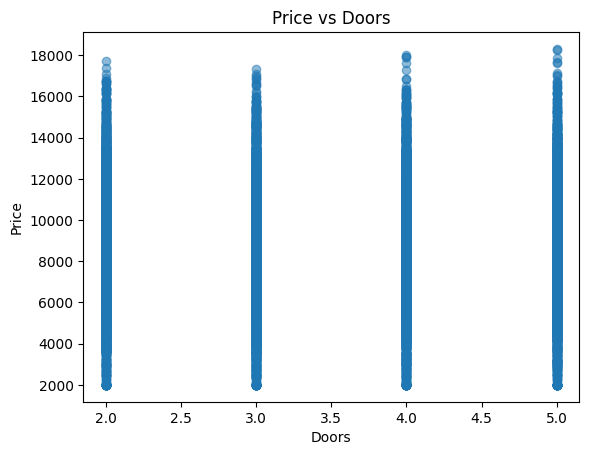

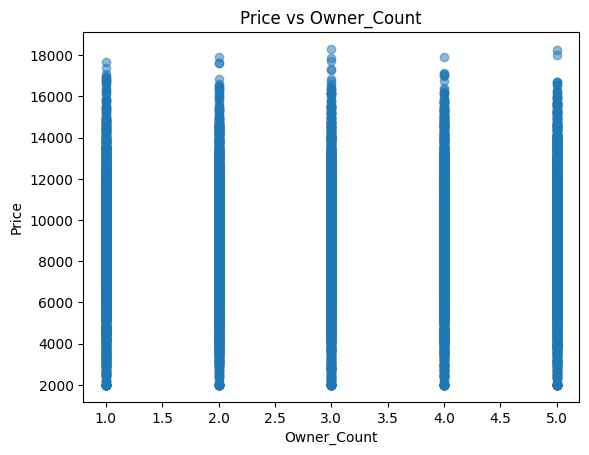

In [12]:
# Här visas hur de numeriska kolumnerna relaterar till pris

numeric_cols = ["Year", "Engine_Size", "Mileage", "Doors", "Owner_Count"]

for col in numeric_cols:
    plt.figure()
    plt.scatter(df[col], df["Price"], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Price")
    plt.title(f"Price vs {col}")
    plt.show()


Och så lite Boxplot mania, courtesy of Linus Staffas!

<Figure size 600x400 with 0 Axes>

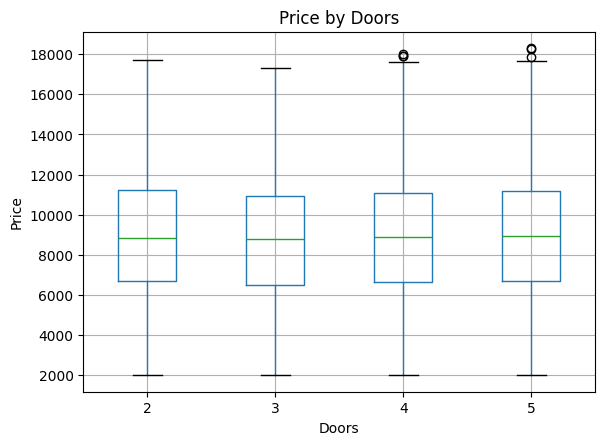

In [13]:
plt.figure(figsize=(6,4))
df.boxplot(column="Price", by="Doors")
plt.title("Price by Doors")
plt.suptitle("")  # tar bort default-titeln "Price by Doors"
plt.xlabel("Doors")
plt.ylabel("Price")
plt.show()


<Figure size 600x400 with 0 Axes>

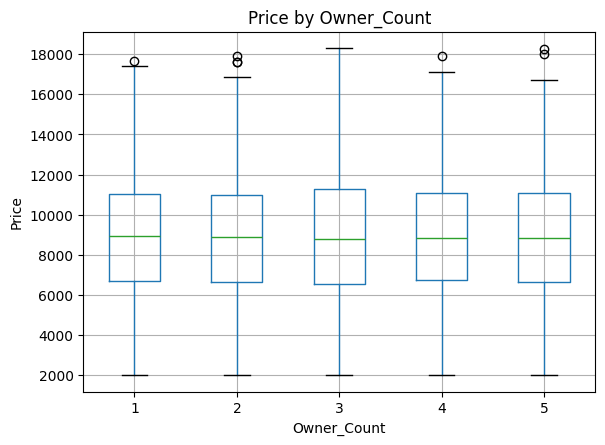

In [14]:
plt.figure(figsize=(6,4))
df.boxplot(column="Price", by="Owner_Count")
plt.title("Price by Owner_Count")
plt.suptitle("")  
plt.xlabel("Owner_Count")
plt.ylabel("Price")
plt.show()


<Figure size 600x400 with 0 Axes>

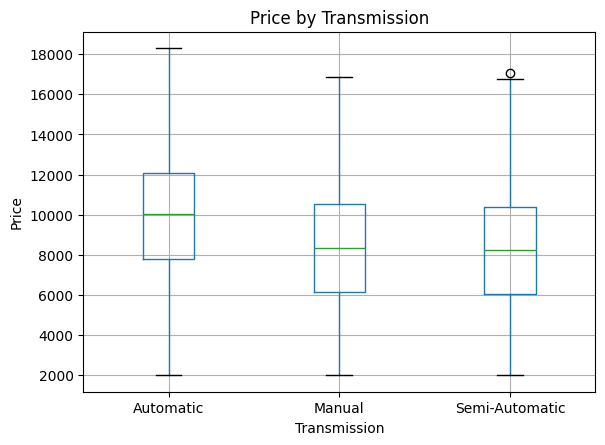

In [15]:
plt.figure(figsize=(6,4))
df.boxplot(column="Price", by="Transmission")
plt.title("Price by Transmission")
plt.suptitle("")   
plt.xlabel("Transmission")
plt.ylabel("Price")
plt.show()


Här är snittpriset för de 15 dyraste modellerna

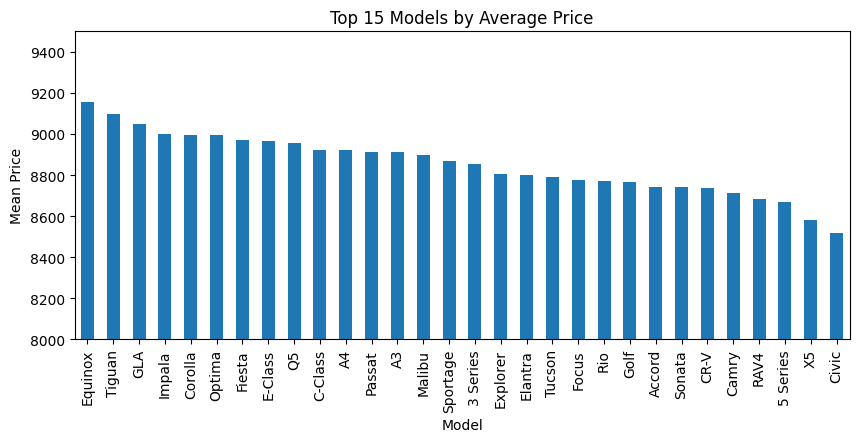

In [16]:
model_price = (
    df.groupby("Model")["Price"]
      .mean()
      .sort_values(ascending=False)
      .head(30)
)

plt.figure(figsize=(10,4))
model_price.plot(kind="bar")
plt.ylabel("Mean Price")
plt.title("Top 15 Models by Average Price")
plt.ylim(8000, 9500)

plt.show()


## Dags att förbereda för träning


Som synes i illustrationen ovan tycks Doors och Owner_Count inte tillföra något mer än brus i vårt dataset. Vi dubbelkollar. 

Vi kör ett feature-set med alla variabler (fortfarande utan brand som vi ju valt bort som implicit bestämt av Model), ett utan doors och owner count, samt ett utan doors respektive owner count. 

In [17]:
base_cols = ["Model", "Year", "Engine_Size", "Fuel_Type",
             "Transmission", "Mileage"]

# Alla variabler
cols_all = base_cols + ["Doors", "Owner_Count"]

# Utan båda
cols_none = base_cols

# Utan Doors (men med Owner_Count)
cols_no_doors = base_cols + ["Owner_Count"]

# Utan Owner_Count (men med Doors)
cols_no_owner = base_cols + ["Doors"]


Vi gör en test med Lasso (endast i syfte att granska relevansen för de två kolumnerna).


In [18]:
def make_X(df, cols):
    X = df[cols]
    return pd.get_dummies(
        X,
        columns=["Model", "Fuel_Type", "Transmission"],
        drop_first=True
    )

def rmse_lasso(X_enc, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X_enc, y, test_size=0.2, random_state=42
    )
    model = Lasso(alpha=0.1, max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))


Och så ska vi se hur RMSE påverkas.

In [19]:
y = df["Price"]

rmse_all      = rmse_lasso(make_X(df, cols_all), y)
rmse_none     = rmse_lasso(make_X(df, cols_none), y)
rmse_no_doors = rmse_lasso(make_X(df, cols_no_doors), y)
rmse_no_owner = rmse_lasso(make_X(df, cols_no_owner), y)

print("RMSE alla features:        ", rmse_all)
print("RMSE utan Doors/Owner:     ", rmse_none)
print("RMSE utan Doors (med Owner)", rmse_no_doors)
print("RMSE utan Owner (med Doors)", rmse_no_owner)


RMSE alla features:         64.73418582536543
RMSE utan Doors/Owner:      64.7130558287325
RMSE utan Doors (med Owner) 64.71547309807511
RMSE utan Owner (med Doors) 64.73198122735877


Det visar alltså att RMSE inte påverkas mer än i mycket liten utsträckning av Doors/Owner, varför dessa slopas i genomgången av modeller.

## Dags att testa modeller

Vi har valt att dela upp modellerna så att alla får arbeta med både linjär och trädbaserad modell. Vi tog ut sex olika modeller, tre av varje, och fördelade mellan oss för att hitta bästa modellerna. 

Jag fick Lasso, ElasticNet och HistGradientBoostingRegressor på min lott. Eftersom det var gott om tid blev det massor av experimenterande också. 

Linus och Carl gjorde sina modeller i egna notebooks och de finns inte med här. Redovisningen av RMSE från dessa kan vid intresse kollas i respektive notebook på begäran. 

En gemensam feature-set för alla modeller.

In [20]:
features = ["Model", "Year", "Engine_Size", "Fuel_Type",
            "Transmission", "Mileage"]
X = df[features]
y = df["Price"]


Så splittar vi upp data för träning, validering och test. Vi sparar 20 % för testningen för att få rimlig utvärdering av modellerna.

In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Här råder viss förvirring. Det har talats om att en sån här split måste göras tidigare, men jag har inte hört någon rimlig förklaring av *varför* och kan inte se hur det som gjorts tidigare i processen kan ha någon som helst bäring på de resultat som vi får i testandet av modeller nedan. 

Enda gången vi nu går tillbaka till de här testdata är när vi valt modell. 

### En preprocessor sköter förbehandling inför modelleringen. 

Med ColumnTransformer kan vi hantera numeriska och kategoriska kolumner i samma pipeline. OneHotEncoder behöver ha Dense output för vissa modeller. 

In [22]:
numeric_features = ["Year", "Mileage", "Engine_Size"]
categorical_features = ["Model", "Fuel_Type", "Transmission"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)


# Lasso



In [24]:
# Tidtagning
start_time = time.time()

# Pipeline
lasso_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso(max_iter=10000))
])

# Hyperparametrar 
lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 1.0]
}

# GridSearchCV 
lasso_grid = GridSearchCV(
    lasso_pipe,
    param_grid=lasso_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

# Träna på rådata-splitten
lasso_grid.fit(X_trainval, y_trainval)

# Slut tidtagning
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)

# Rapportera resultat
print("Bästa alpha:", lasso_grid.best_params_)
print("CV-RMSE:", -lasso_grid.best_score_)
print(f"Modelleringstid: {int(minutes)} minuter och {seconds:.1f} sekunder")

Bästa alpha: {'model__alpha': 0.1}
CV-RMSE: 88.96104267896813
Modelleringstid: 0 minuter och 1.5 sekunder


Alpha ska alltså vara 0,1 och RMSE för korsvalideringen är ca 88,96. 

## För att kunna jämföra modellerna på slutet gör vi en smidig resultathantering. 

In [27]:
results = []

results.append({
    "model": "Lasso",
    "cv_rmse": -lasso_grid.best_score_,
    "elapsed_s": elapsed
})

# Elasticnet


In [28]:
# Tidtagning
start_time = time.time()

# Pipeline
elastic_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ElasticNet(max_iter=10000))
])

# Hyperparametrar
elastic_param_grid = {
    "model__alpha": [0.01, 0.1, 1.0, 10],
    "model__l1_ratio": [0.2, 0.5, 0.8, 1.0]
}

# GridSearchCV 
elastic_grid = GridSearchCV(
    elastic_pipe,
    param_grid=elastic_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

# Träna modellen
elastic_grid.fit(X_trainval, y_trainval)

# Slut tidtagning
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)

# Rapportera resultat
print("Bästa hyperparametrar:", elastic_grid.best_params_)
print("CV-RMSE ElasticNet:", -elastic_grid.best_score_)
print(f"Modelleringstid: {int(minutes)} minuter och {seconds:.1f} sekunder")

Bästa hyperparametrar: {'model__alpha': 0.1, 'model__l1_ratio': 1.0}
CV-RMSE ElasticNet: 88.96104267896813
Modelleringstid: 0 minuter och 3.6 sekunder


Resultat

In [29]:
results.append({
    "model": "ElasticNet",
    "cv_rmse": -elastic_grid.best_score_,
    "elapsed_s": elapsed
})


# HistGradientBoostingRegressor


In [30]:
# Tidtagning
start_time = time.time()

# Pipeline
hgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", HistGradientBoostingRegressor(random_state=123))
])

# Hyperparametrar
hgb_param_grid = {
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [None, 3, 5],
    "model__max_iter": [200, 300, 500],
    "model__min_samples_leaf": [20, 50, 100]
}

# GridSearchCV
hgb_grid = GridSearchCV(
    hgb_pipe,
    param_grid=hgb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

# Träna modellen
hgb_grid.fit(X_trainval, y_trainval)

# Slut tidtagning
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)

# Rapportera resultat
print("Bästa hyperparametrar:", hgb_grid.best_params_)
print("CV-RMSE HGB:", -hgb_grid.best_score_)
print(f"Modelleringstid: {int(minutes)} minuter och {seconds:.1f} sekunder")


Bästa hyperparametrar: {'model__learning_rate': 0.05, 'model__max_depth': None, 'model__max_iter': 500, 'model__min_samples_leaf': 20}
CV-RMSE HGB: 131.97894724372517
Modelleringstid: 0 minuter och 34.2 sekunder


Resultat

In [31]:
results.append({
    "model": "HistGradientBoostingRegressor",
    "cv_rmse": -hgb_grid.best_score_,
    "best_params": hgb_grid.best_params_,
    "elapsed_s": elapsed
})

# KNeighborsRegressor

In [32]:
# Tidtagning
start_time = time.time()

# Pipeline
knn_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KNeighborsRegressor())
])

# Hyperparametrar
knn_param_grid = {
    "model__n_neighbors": [5, 10, 20, 40, 80],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

# GridSearchCV
knn_grid = GridSearchCV(
    knn_pipe,
    param_grid=knn_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

knn_grid.fit(X_trainval, y_trainval)

# Slut tidtagning
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)

# Rapportera resultat
print("Bästa hyperparametrar:", knn_grid.best_params_)
print("CV-RMSE KNN:", -knn_grid.best_score_)
print(f"Modelleringstid: {int(minutes)} minuter och {seconds:.1f} sekunder")


Bästa hyperparametrar: {'model__n_neighbors': 20, 'model__p': 2, 'model__weights': 'uniform'}
CV-RMSE KNN: 485.6442703096924
Modelleringstid: 0 minuter och 1.5 sekunder


Resultat

In [33]:
results.append({
    "model": "KNeighborsRegressor",
    "cv_rmse": -knn_grid.best_score_,
    "best_params": knn_grid.best_params_,
    "elapsed_s": elapsed
})


# Resultat
Nedan är resultaten för modellerna i denna notebook. Resultat för de övriga deltagarnas modeller finns längre ned.

In [34]:
# Vi gör en dataframe av resultaten vi samlat in
results_df = pd.DataFrame(results)

# Parametrar är insamlade, men vi lämnar dem därhän och nöjer oss med
# modell, RMSE och tidsåtgång 
summary_df = (
    results_df[["model", "cv_rmse", "elapsed_s"]]
    .rename(columns={
        "model": "Modell",
        "cv_rmse": "CV-RMSE",
        "elapsed_s": "Tid (s)"
    })
)

display(
    summary_df.sort_values("CV-RMSE").reset_index(drop=True)
)

,Modell,CV-RMSE,Tid (s)
0,Lasso,88.961043,0.250929
1,ElasticNet,88.961043,3.590248
2,HistGradientBoostingRegressor,131.978947,34.234455
3,KNeighborsRegressor,485.644270,1.470714


Utifrån dessa RMSE‑resultat tycks de linjära modellerna (Lasso och ElasticNet) vara klart mest lämpliga för det här datasetet, medan trädmodellerna HistGradientBoostingRegressor och KNeighborsRegressor ger betydligt större fel trots finslipning av hyperparametrarna.

Man blir nästan lite misstänksam när de enklaste(?) modellerna ger ett så litet fel som 89. Men det är väl bara att tacka och ta emot ... :D

# Resultat Linus

### Resultat från jämförelse‑notebook

| Modell           | RMSE (validering) |
|-----------------|-------------------|
| SVR_RBF         | 65.02             |
| SVR_Lin         | 88.29             |
| ElasticNet      | 89.00             |
| Ridge           | 89.05             |
| LinearRegression| 90.11             |
| DecisionTree    | 756.03            |


*Kommentar*:    
    Här har vi vad som kan vara en "winner". 
    Betydligt bättre än någon av modellerna ovan. 

    Nu blir det spännande att se vad Carl får för resultat av sina modeller. 

# Resultat Carl

### Resultat från jämförelse‑notebook

| Modell            | RMSE (validering) |
|-------------------|-------------------|
| Poly              | 86,90             |
| ElasticNet        | 90.54             |
| Kneighbors        | 485.64            |
| RandomForest      | 610.15            |


# (no) Bonus
Här fanns tidigare ett antal ytterligare modeller som gjordes bara för att kolla (det var gott om tid), men ingen av dem presterade särskilt bra så de ströks. Även diverse experimenterande som bröt mot reglerna för att tjuvkika på hur modellerna presterar på testdata har strukits efter allmän diskussion om detta. 


# Vinnarmodellen! 

Så ska vi ta en närmare titt på den modell som presterade bäst. Linus SVR med rdf-kernel var bäst, men varför inte kolla lite fler SVR "just in case". 

SVR verkar ha fått bäst resultat i gruppen. Tar en liten titt. Vi börjar med en linjär modell. 

In [35]:
# Tidtagning
start_time = time.time()

# Pipeline
svr_model_linear = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVR(kernel="linear"))
])

# Parameterraster 
param_grid_svr_linear = {
    "model__C": [10, 300], #skalat ned av tidsskäl
    "model__epsilon": [0.1, 0.5] # skalat ned av tidsskäl
}

# Korsvalidering
cv = KFold(n_splits=5)

svr_grid_linear = GridSearchCV(
    estimator=svr_model_linear,
    param_grid=param_grid_svr_linear,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=3
)

# Träna modellen
svr_grid_linear.fit(X_trainval, y_trainval)

# Slut tidtagning
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)

# Rapportera resultat
print("Bästa hyperparametrar SVR (linear):", svr_grid_linear.best_params_)
print("CV-RMSE SVR (linear, train/val):", -svr_grid_linear.best_score_)
print(f"Modelleringstid: {int(minutes)} minuter och {seconds:.1f} sekunder")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Bästa hyperparametrar SVR (linear): {'model__C': 10, 'model__epsilon': 0.5}
CV-RMSE SVR (linear, train/val): 90.74277936578869
Modelleringstid: 4 minuter och 14.6 sekunder


Vi fortsätter med resultaten.

In [36]:
results.append({
    "model": "SVR (linear)",
    "cv_rmse": -svr_grid_linear.best_score_,
    "best_params": svr_grid_linear.best_params_,
    "elapsed_s": elapsed
})


I testen av SVR upptäckte vi att det var en dålig idé att slarva med hyperparameterar i GridSearchCV. Det blev oerhört tungt för datorn att tugga igenom med fel värden och först efter ett antal experiment visade det sig att ett för högt C-värde och för många parametrar tog väldigt lång tid.   

Vi tar en ny SVR-modell

In [37]:
# Tidtagning
start_time = time.time()

# Pipeline
svr_poly_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVR(kernel="poly"))
])

# Hyperparametrar
param_grid_svr_poly = {
    "model__C": [10, 300],
    "model__epsilon": [0.1, 0.5],
    "model__degree": [2, 3]
}

# CV
cv = KFold(n_splits=5)

svr_grid_poly = GridSearchCV(
    estimator=svr_poly_pipe,
    param_grid=param_grid_svr_poly,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=3
)

# Träna på train/val
svr_grid_poly.fit(X_trainval, y_trainval)

# Slut tidtagning
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)

# Rapportera resultat
print("Bästa hyperparametrar SVR (poly):", svr_grid_poly.best_params_)
print("CV-RMSE SVR (poly, train/val):", -svr_grid_poly.best_score_)
print(f"Modelleringstid: {int(minutes)} minuter och {seconds:.1f} sekunder")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Bästa hyperparametrar SVR (poly): {'model__C': 300, 'model__degree': 2, 'model__epsilon': 0.5}
CV-RMSE SVR (poly, train/val): 90.71719422487595
Modelleringstid: 17 minuter och 36.9 sekunder


Resultat

In [38]:
results.append({
    "model": "SVR (polynomial)",
    "cv_rmse": -svr_grid_poly.best_score_,
    "best_params": svr_grid_poly.best_params_,
    "elapsed_s": elapsed
})


*//Side note: Tidsåtgången påverkas kraftigt när bearbetningen görs samtidigt som datorn håller på med andra processer parallellt, särskilt videosamtal (föreläsningen). Därför körs hela notebooken om "rent" före inlämning så att tiderna blir rättvisa.//*

Och så en sista SVR - detta är den modell som vi upptäckte gav bäst resultat "out of the box" och ger ett enastående RMSE.       

In [39]:
# Tidtagning
start_time = time.time()

# Pipeline
svr_rbf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVR(kernel="rbf"))
])

# Hyperparametrar
param_grid_svr_rbf = {
    "model__C": [100, 300, 1000],
    "model__epsilon": [0.01, 0.1, 0.5],
    "model__gamma": [0.03, 0.05, 0.1]
}

# Korsvalidering
cv = KFold(n_splits=5)

svr_grid_rbf = GridSearchCV(
    estimator=svr_rbf_pipe,
    param_grid=param_grid_svr_rbf,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=3
)

# Träna på train/val
svr_grid_rbf.fit(X_trainval, y_trainval)

# Slut tidtagning
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)

# Rapportera resultat
print("Bästa hyperparametrar SVR (rbf):", svr_grid_rbf.best_params_)
print("CV-RMSE SVR (rbf, train/val):", -svr_grid_rbf.best_score_)
print(f"Modelleringstid: {int(minutes)} minuter och {seconds:.1f} sekunder")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Bästa hyperparametrar SVR (rbf): {'model__C': 1000, 'model__epsilon': 0.5, 'model__gamma': 0.1}
CV-RMSE SVR (rbf, train/val): 65.96334585161728
Modelleringstid: 3 minuter och 23.2 sekunder


Resultat

In [40]:
results.append({
    "model": "SVR (RBF)",
    "cv_rmse": -svr_grid_rbf.best_score_,
    "best_params": svr_grid_rbf.best_params_,
    "elapsed_s": elapsed
})


För att inte riskera att jämförelserna skevas mot andra modeller så har vi strukit Shuffle som vi experimenterade med. Det gjorde väldigt lite skillnad på slutresultatet ändå, och kunde lika gärna tagits med eftersom det sannolikt inte blir skillnad ändå när man har samma randomisering. 

Dataunderlaget är dock inte av sådan art att Shuffle behövs. Om materialet varit sorterat på något vis kunde det varit en intressant vinkling för att få bättre resultat. 

Ny rapport av resultaten.

In [47]:
# Vi gör en dataframe av resultaten vi samlat in
results_df = pd.DataFrame(results)

# Nu tar vi även med de bästa hyperparametrarna
params_df = results_df["best_params"].apply(pd.Series)

# En enkel "effektivitets-score": felinverterad och tidsviktad
results_df["rmse_score"] = 1 / (results_df["cv_rmse"] * results_df["elapsed_s"]) * 1000

summary_df = pd.concat(
    [
        results_df[["model", "cv_rmse", "elapsed_s", "rmse_score"]],
        params_df
    ],
    axis=1
).rename(columns={
    "model": "Modell",
    "cv_rmse": "CV-RMSE",
    "elapsed_s": "Tid (s)",
    "rmse_score": "RMSE-score"
})

display(
    summary_df.sort_values("CV-RMSE", ascending=False).reset_index(drop=True)
)


,Modell,CV-RMSE,Tid (s),RMSE-score,0,model__learning_rate,model__max_depth,model__max_iter,model__min_samples_leaf,model__n_neighbors,model__p,model__weights,model__C,model__epsilon,model__degree,model__gamma
0,KNeighborsRegressor,485.644270,1.470714,1.400082,NaN,NaN,NaN,NaN,NaN,20.0,2.0,uniform,NaN,NaN,NaN,NaN
1,HistGradientBoostingRegressor,131.978947,34.234455,0.221326,NaN,0.05,NaN,500.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SVR (linear),90.742779,254.626689,0.043280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5,NaN,NaN
3,SVR (polynomial),90.717194,1056.885370,0.010430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,0.5,2.0,NaN
4,Lasso,88.961043,0.250929,44.797100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ElasticNet,88.961043,3.590248,3.130947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SVR (RBF),65.963346,203.221945,0.074598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.5,NaN,0.1


# Slutsats
## Bästa RMSE ger SVR med rbf-kernel. 
RBF (Radial Basis Function) är den så kallade gaussiska kerneln och presterar utmärkt i det här dataunderlaget eftersom modellen tar hänsyn både till de linjära sambanden och mer komplexa mönster, som att olika modeller har olika prisfall, att prisfallet är störst i början och olika  kluster kan finnas i underlaget. RBF-kerneln arbetar i ett högdimensionellt rum som också passar utmärkt för de dummy-kodade kategorierna. 

## Bästa prestanda med rimlig RMSE ger Lasso.
Lasso är en enkel modell som passar utmärkt för de linjära samband som finns i underlaget och går oerhört fort att köra jämfört med SVR-modellen.

## Valet av modell får nu bli kundens. Vill denne ha bäst RMSE eller även snegla på en modell som är lätt att hantera och har enastående prestanda?


Vi antar att kunden fokuserar på bästa RMSE och att denne väljer SVR med rbf-kernel. Det är så slutligen dags att köra modellen mot våra testdata och se vad vi får för resultat. 

In [42]:
best_svr_rbf = svr_grid_rbf.best_estimator_
y_pred_test_rbf = best_svr_rbf.predict(X_test)
rmse_test_rbf = np.sqrt(mean_squared_error(y_test, y_pred_test_rbf))

print("Test-RMSE SVR (rbf):", rmse_test_rbf)


Test-RMSE SVR (rbf): 50.29276489757912


Enastående. Med RMSE på bara drygt 50 dollar är modellen mycket pricksäker. Nästan så man är orolig för att den är **för** pricksäker, men efter en del felsökning tycks det inte vara något som är fel. 

Det hade, enligt *Principle of parsimony*, kanske ändå varit klokare av kunden att välja Lasso. Men vi vet alla hur det heter, **"The Customer is Always Right!"**. 



Bonusavslutning. Enjoy!

In [43]:
# En liten prediktor för bilpris

# Validering av indata
valid_models = sorted(df["Model"].unique())
valid_fuel = sorted(df["Fuel_Type"].unique())
valid_trans = sorted(df["Transmission"].unique())

median_year = int(df["Year"].median())
median_engine = float(df["Engine_Size"].median())
median_mileage = int(df["Mileage"].median())

# Var noga med inmattningen
def ask_choice(prompt, valid_values):
    print(f"{prompt} (tillåtna: {', '.join(valid_values)})")
    val = input("-> ").strip()
    while val not in valid_values:
        print("Ogiltigt värde, försök igen.")
        val = input("-> ").strip()
    return val

# Hjälp till med default
def ask_int(prompt, default):
    txt = input(f"{prompt} (Enter för {default}): ").strip()
    if txt == "":
        return default
    while True:
        try:
            return int(txt)
        except ValueError:
            txt = input("Skriv ett heltal: ").strip()

# Och default även här
def ask_float(prompt, default):
    txt = input(f"{prompt} (Enter för {default}): ").strip()
    if txt == "":
        return default
    while True:
        try:
            return float(txt)
        except ValueError:
            txt = input("Skriv ett tal (t.ex. 2.0): ").strip()

# Så kör vi
def predict_price_interval(model):
    print("\n--- Välj bil ---")
    m = ask_choice("Modell", valid_models)
    f = ask_choice("Bränsletyp", valid_fuel)
    t = ask_choice("Växellåda", valid_trans)
    y = ask_int("Årsmodell", median_year)
    e = ask_float("Motorstorlek (liter)", median_engine)
    km = ask_int("Miltal", median_mileage)

    # Bygg en rad med samma struktur som träningsdatan
    X_new = pd.DataFrame([{
        "Brand": df["Brand"].iloc[0],      # eller välj brand separat om du vill fråga efter det också
        "Model": m,
        "Year": y,
        "Engine_Size": e,
        "Fuel_Type": f,
        "Transmission": t,
        "Mileage": km
    }])

    # Prediktion
    pred = model.predict(X_new)[0]

    # Prisintervall: ±50 (eftersom det är rmse för bästa modellen) 
    rmse = 50.0
    lower = max(0, pred - rmse)
    upper = pred + rmse

    print(f"\nFör en {y} {m} ({e}L, {f}, {t}, {km} mil)")
    print(f"beräknar modellen ett pris på cirka ${pred:,.0f} ")
    print(f"med ett ungefärligt intervall ${lower:,.0f}–{upper:,.0f} ")

# Så kör vi!
predict_price_interval(best_svr_rbf)




--- Välj bil ---
Modell (tillåtna: 3 Series, 5 Series, A3, A4, Accord, C-Class, CR-V, Camry, Civic, Corolla, E-Class, Elantra, Equinox, Explorer, Fiesta, Focus, GLA, Golf, Impala, Malibu, Optima, Passat, Q5, RAV4, Rio, Sonata, Sportage, Tiguan, Tucson, X5)
Bränsletyp (tillåtna: Diesel, Electric, Hybrid, Petrol)
Växellåda (tillåtna: Automatic, Manual, Semi-Automatic)

För en 2008 A3 (2.0L, Petrol, Manual, 275000 mil)
beräknar modellen ett pris på cirka $3,018 
med ett ungefärligt intervall $2,968–3,068 
